# Multi-materials simulation

In this demo, we will perform a H transport simulation with coupled heat transfer.


## 1. Problem definition

 <p align="center">
  <img src="https://user-images.githubusercontent.com/40028739/104934903-e10d7500-59aa-11eb-9296-17de99140701.jpg" width="40%">
</p>


- $D(T) = 4.1\times 10^{-7} \exp{(-0.39/k_B T)}$
- Trap:
    - Density: $n_1 = 1.3\times 10^{-3} \text{ at.fr.}$
    - Trapping rate: $k(T) = 3.8 \times 10^{-17} \exp{(-0.39/k_B T)} \text{ s}^{-1}$
    - Detrapping rate: $p(T) = 8.4\times 10^{12} \exp{(-1.2/k_B T)} \text{ s}^{-1}$



A Dirichlet boundary conditions will be imposed on $\Gamma_\mathrm{left}$ and a recombination flux is imposed on $\Gamma_\mathrm{right}$.

- $c_\mathrm{m} = 10^{20} \; \mathrm{m}^{-3} \quad \text{on } \Gamma_\mathrm{left}$
- $-D \nabla c_\mathrm{m} \cdot n = -K c_\mathrm{m}^2 \quad \text{on }\Gamma_\mathrm{right}$
with $K = 2.9\times 10^{-14} \exp{(-1.92/k_B T)} \; \mathrm{m}^4 \mathrm{s}^{-1}$

## 2. Implementation
The first step is to create an empty parameters dictionnary

In [1]:
parameters = {}

### 2.1 Materials.
`"E_D"` is the energy barrier for diffusion expressed in $\text{eV}$.

`"D_0"` is the pre-exponential factor of the Arhenius' law for the diffusion coefficient expressed in $\text{m}^{2}\text{s}^{-1}$.

Finally, `"id"` is the id of the material subdomain. This will be needed later on.

In [2]:
def thermal_cond(T):
    return 3 + 0.1*T

parameters["materials"] = [
    {
    "E_D": 0.39,
    "D_0": 4.1e-7,
    "thermal_cond": thermal_cond,
    "id": 1
    }
]

### 2.2 Meshing
Now it's time to create a mesh for our simulation. One way of creating a 1D mesh in FESTIM is to directly provide the mesh coordinates (vertices). In this case, we want 200 nodes in the left sub-domain, 100 nodes in the middle one and finally 200 cells in right sub-domain.

In [3]:
from fenics import Point, CompiledSubDomain, MeshFunction, plot
from mshr import Rectangle, Circle, generate_mesh
# creating a mesh with FEniCS
lx = ly = 10
cx = cy = lx / 2.0
radius = 2.5
res = 30
rectangle = Rectangle(Point(0, 0), Point(lx, ly))
hole = Circle(Point(cx, cy), radius)
mesh_fenics = generate_mesh(rectangle - hole, res)

# marking physical groups (volumes and surfaces)
volume_markers = MeshFunction("size_t", mesh_fenics, mesh_fenics.topology().dim())
volume_markers.set_all(1)

tol = 1e-14
left_surface = CompiledSubDomain('on_boundary && near(x[0], 0, tol)',
                                tol=tol)
right_surface = CompiledSubDomain('on_boundary && near(x[0], lx, tol)',
                                     tol=tol, lx=lx)
top_surface = CompiledSubDomain('on_boundary && near(x[1], ly, tol)',
                                     tol=tol, ly=ly)
bottom_surface = CompiledSubDomain('on_boundary && near(x[1], 0, tol)',
                                     tol=tol)
surface_markers = MeshFunction("size_t", mesh_fenics, mesh_fenics.topology().dim() - 1)
surface_markers.set_all(0)
left_surface.mark(surface_markers, 1)
top_surface.mark(surface_markers, 2)
right_surface.mark(surface_markers, 3)
bottom_surface.mark(surface_markers, 4)

# creating mesh with FESTIM
parameters["mesh_parameters"] = {
    "mesh": mesh_fenics,
    "meshfunction_cells": volume_markers,
    "meshfunction_facets": surface_markers,
}


### 2.3 Traps
In FESTIM, each trap is defined by a dictionary with the following keys:

`"k_0"` and `"E_k"` are the trapping rate pre-exponential factor in $\text{m}^{3} \text{s}^{-1}$ and activation energy in $\text{eV}$.

`"p_0"` and `"E_p"` are the detrapping rate pre-exponential factor in $\text{s}^{-1}$ and activation energy in $\text{eV}$.

`"materials"` is a list of the materials' ids where the trap is.

For this example, there will be one trap in the tungsten parts (`trap_tunsgten`) and a trap in the copper layer (`trap_copper`).

In [4]:
parameters["traps"] = [
    {
    "k_0": 3.8e-17,
    "E_k": 0.39,
    "p_0": 8.4e12,
    "E_p": 0.9,
    "density": 1e25,
    "materials": [1]
}
]

### 2.4 Temperature
The temperature in this example will be $320 \text{K}$ in the whole domain.

In [5]:
import sympy as sp
from FESTIM import x, y

parameters["temperature"] = {
    "type": "solve_stationary",
    "boundary_conditions": [
        {
            "type": "dc",
            "surfaces": [1, 2],
            "value": 350 + 20*sp.cos(x)*sp.sin(y),
        },
        {
            "type": "convective_flux",
            "surfaces": [0],
            "h_coeff": 100*x,
            "T_ext": 300 + 3*y
        },
        {
            "type": "flux",
            "surfaces": [3, 4],
            "value": 10 + 3*sp.cos(x) + sp.sin(y),
        },
    ],
    "source_term": [
        {
            "value": 1 + 0.1*x,
            "volume": 1
        },
    ]
}

### 2.5 Boundary conditions
A Dirichlet boundary condition is imposed on the left surface (1) whereas a second order recombination flux is assumed on the right surface.

In [6]:
boundary_conditions = [
            {
                "surfaces": [1, 2, 3],
                "value": 1e19*(1 + sp.cos(x)),
                "type": "dc"
                
            },

            {
                "surfaces": [0],
                "type": "recomb",
                "Kr_0": 1e-7,
                "E_Kr": 1,
                "order": 2,
            }
    ]

parameters["boundary_conditions"] = boundary_conditions

### 2.6 Exports
All the output files will be exported in a directory named **outputs**.
The two types of derived quantities we are interested in are **volume integrations** of the solute and trapped concentrations as well as the computation of **fluxes on surfaces**.

In [7]:
exports = {
    "xdmf": {
        "functions": ['1', 'solute', 'retention', 'T'],
        "labels": ['1', 'solute', 'retention', 'T'],
        "folder": 'outputs',
    },
}

parameters["exports"] = exports

### 2.7 Solving parameters
The simulation will last $17 000$ s and the initial stepsize is $50$ s.

It is recommended to set the `"traps_element_type"` key to `"DG"` (Discontinuous Galerkin) when dealing with multiple materials. This is because the trapped concentration fields won't be continuous (discontinuities at interfaces) and could lead to interpolation issues.

In [8]:
solving_parameters = {
    "type": "solve_stationary",

    "newton_solver": {
        "absolute_tolerance": 1e10,
        "relative_tolerance": 1e-9,
        "maximum_iterations": 50,
    },

}

parameters["solving_parameters"] = solving_parameters

### 2.8 Run the simulation

In [9]:
from FESTIM.generic_simulation import run
output = run(parameters)

Defining variational problem heat transfers
Solving stationary heat equation
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Defining initial values
Defining variational problem
Defining boundary conditions
Solving steady state problem...


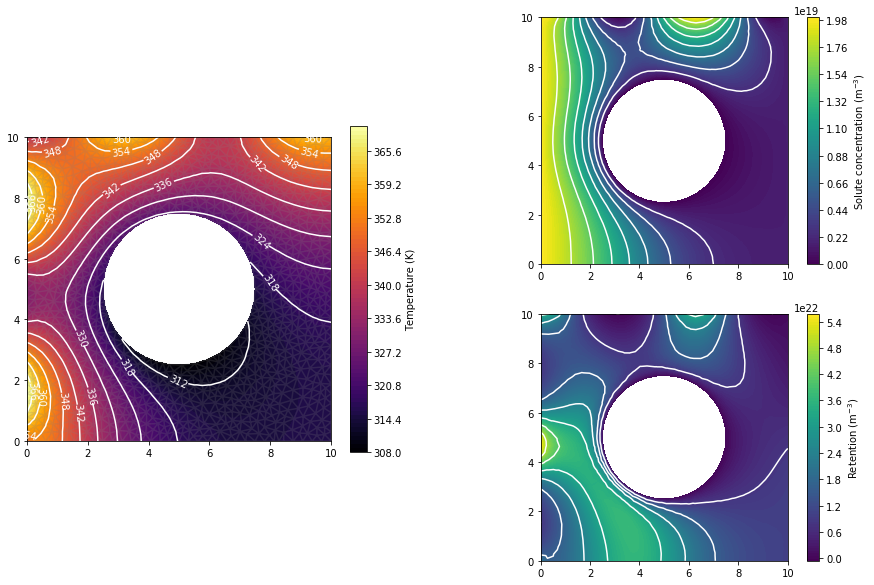

In [24]:
from fenics import XDMFFile, FunctionSpace, Function, plot, Mesh
import matplotlib.pyplot as plt


def load_field(mesh, fieldfile, field, element="CG", counter=-1):

    V = FunctionSpace(mesh, element, 1)
    u = Function(V)

    XDMFFile(fieldfile).read_checkpoint(u, field, counter)
    return u


# get the mesh from the output
mesh = output["mesh"]
T = load_field(mesh, "outputs/T.xdmf", "T")
solute = load_field(mesh, "outputs/solute.xdmf", "solute", element="DG")
trap1 = load_field(mesh, "outputs/1.xdmf", "1")
retention = load_field(mesh, "outputs/retention.xdmf", "retention")

plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
CF = plot(T, cmap="inferno", levels=100)
plot(mesh, alpha=0.2)
CS = plot(T, mode="contour", colors="white", levels=10)
CL = plt.clabel(CS, inline=True, fmt='%.f')
CB = plt.colorbar(CF, shrink=0.6, label="Temperature (K)")

plt.subplot(2, 2, 2)
CF = plot(solute, levels=100)
CS = plot(solute, mode="contour", colors="white", levels=8)
CB = plt.colorbar(CF, label="Solute concentration (m$^{-3}$)")

plt.subplot(2, 2, 4)
CF = plot(retention, levels=100)
CS = plot(retention, mode="contour", colors="white", levels=8)
CB = plt.colorbar(CF, label="Retention (m$^{-3}$)")

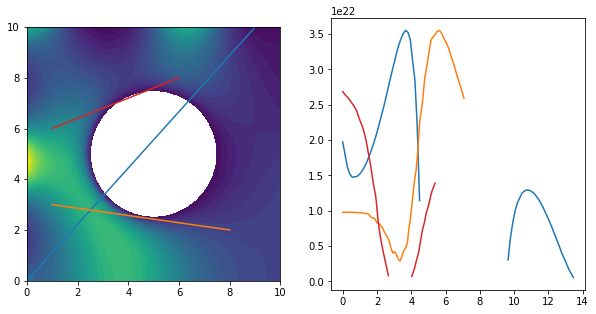

In [11]:
import numpy as np
def profile(function, start_point, end_point, nb):
    points_x = np.linspace(start_point[0], end_point[0], num=nb)
    points_y = np.linspace(start_point[1], end_point[1], num=nb)
    z, arc_length = [], []
    for i in range(len(points_x)):
        try:
            z.append(function(points_x[i], points_y[i]))
        except RuntimeError:
            z.append(float("nan"))
            
        arc_length.append(np.linalg.norm(np.array([points_x[i], points_y[i]]) - np.array(start_point)))

        
    return z, arc_length, points_x, points_y
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

plt.sca(axs[0])
plot(retention)

start_points = [(0, 0), (8, 2), (1, 6)]
end_points = [(9, 10), (1, 3), (6, 8)]
colours = ["tab:blue", "tab:orange", "tab:red"]
for start_point, end_point, colour in zip(start_points, end_points, colours):
    
    z, arc_length, points_x, points_y = profile(retention, start_point, end_point, nb=100)
    plt.sca(axs[0])
    plt.plot(points_x, points_y, color=colour)
    plt.sca(axs[1])
    plt.plot(arc_length, z, color=colour)


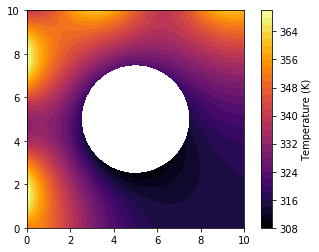

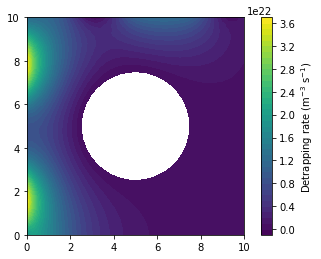

In [27]:
from fenics import exp
from FESTIM import k_B

CF = plot(T, cmap="inferno")
CB = plt.colorbar(CF, label="Temperature (K)")
plt.show()

p = 8.4e12*exp(-0.9/k_B/T)
CF = plot(p*trap1)
CB = plt.colorbar(CF, label="Detrapping rate (m$^{-3}$ s$^{-1}$)")
plt.show()